<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/06-generate-protein-structures/03_generating_crystal_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating Crystal Structures with CrystaLLM

CrystaLLM is distinct because it is the first one trained on textual representations of crystallographic information
files (CIF), rather than traditional chemical representations.

This approach rests on two main conjectures:

* first, that sequences of symbols can represent
complex chemical structures;
* and second, that LLMs can learn deeper causal
relationships in the data, beyond simple correlations.

The model has been trained on extensive CIF data, enabling it to generate physically plausible inorganic crystal structures.

During training, the model is given a sequence of tokens from a corpus of CIF files and is tasked with predicting the tokens which follow each of the given tokens.

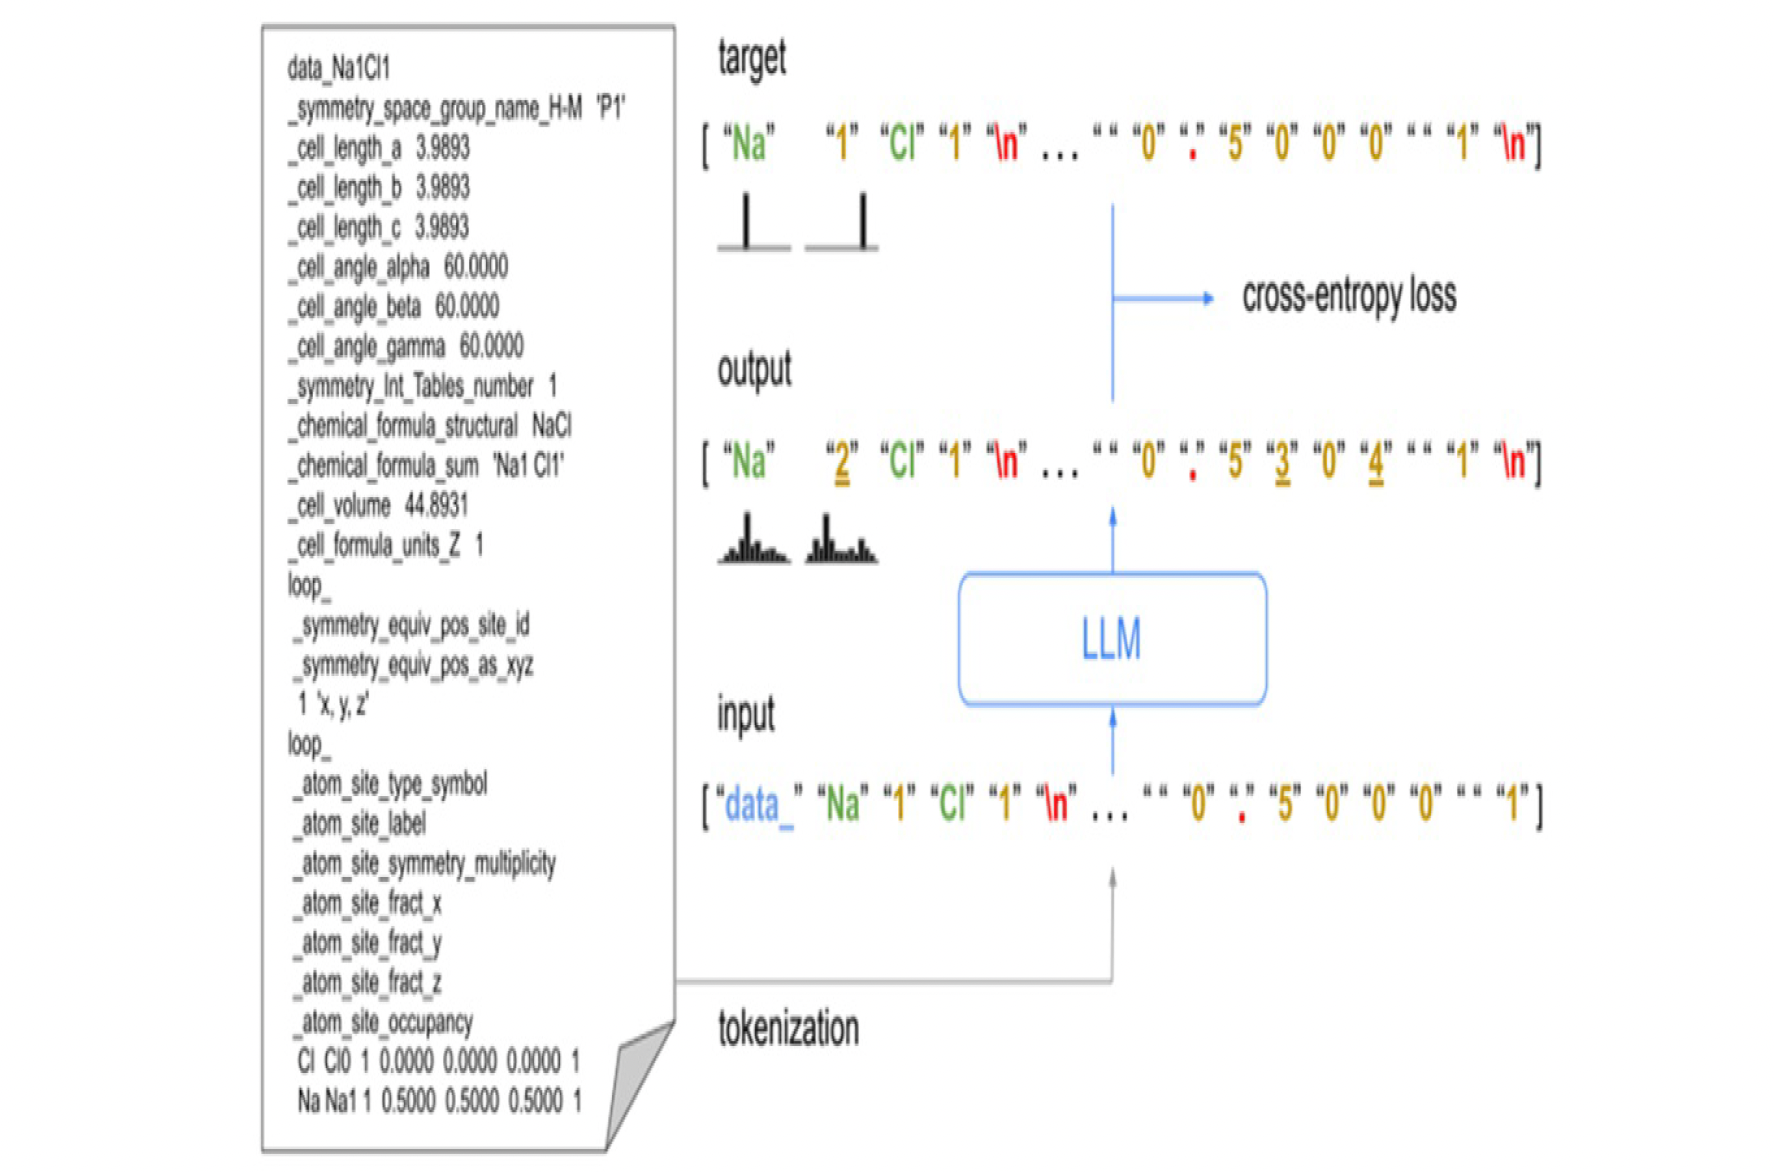

Once the model is trained, it can be used to generate new CIF
files, conditioned on some starting sequence of tokens. Generating a CIF file involves repeatedly sampling tokens from the model, conditioning on the accumulated generated content, until a terminating condition is reached.

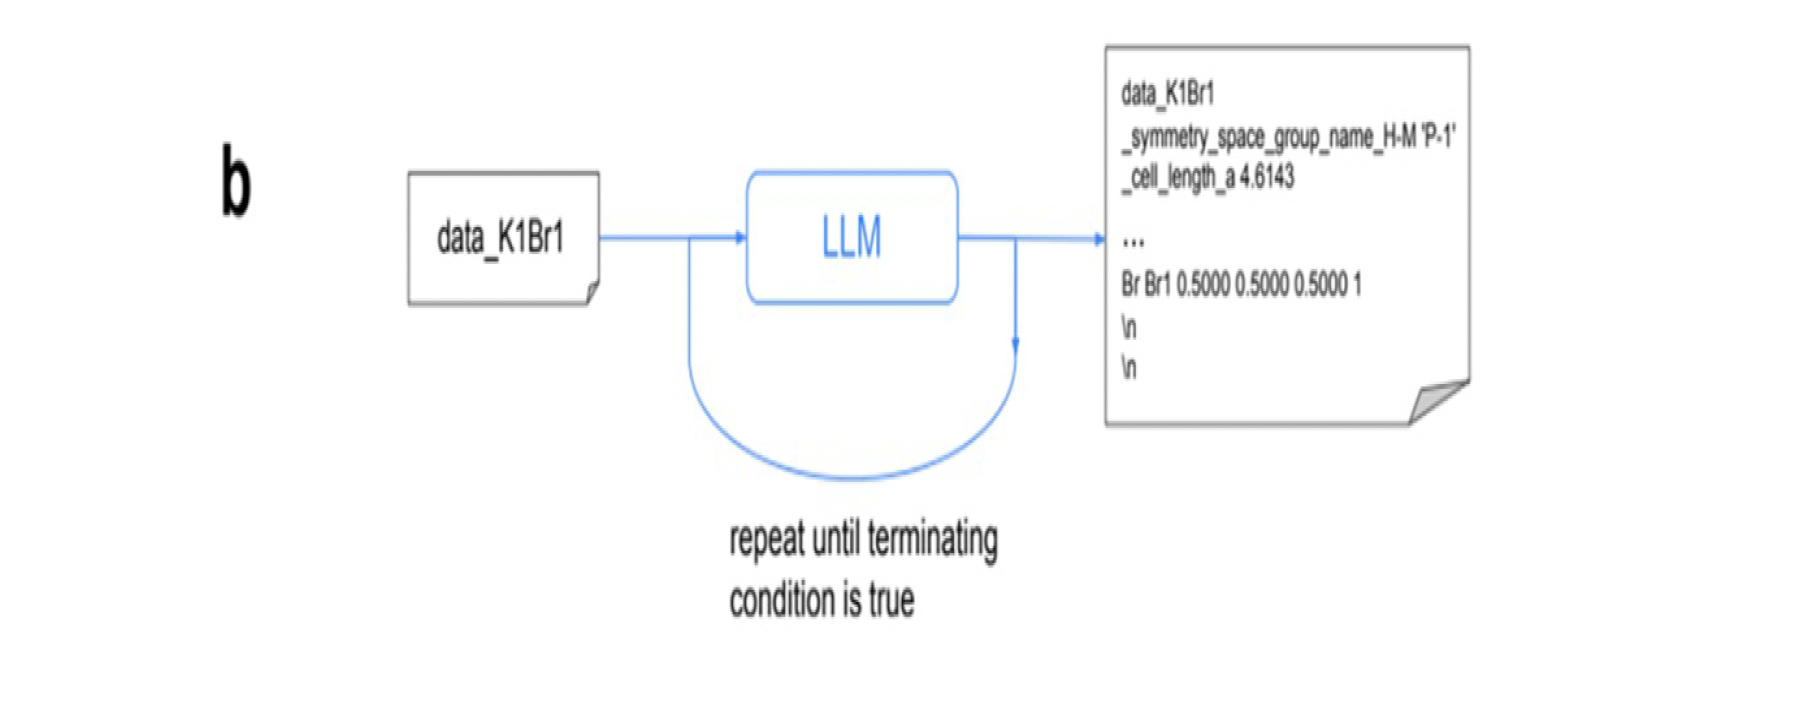

This sequence is processed by the model, which produces a list of probability distributions over the vocabulary,
for each corresponding symbol in the input. The resulting predicted probability distributions are evaluated against the target distributions, using the cross-entropy loss metric.

The code in this notebook is to generate and evaluate crystal structures using the [CrystaLLM](https://github.com/lantunes/CrystaLLM) model. It doesn't require hardware acceleration.

## Setup

Clone the CrystaLLM repo.

In [ ]:
!git clone https://github.com/lantunes/CrystaLLM.git

Install the missing requirements. Only Pymatgen (Python Materials Genomics, a robust Open Source library for materials analysis) and OmegaConf (a YAML based hierarchical configuration system) are missing in the Colab VMs.

In [ ]:
!pip install pymatgen omegaconf

Add the CrystaLLM path to the Python path.

In [1]:
import sys
import os

sys.path.append('/content/CrystaLLM')
os.environ["PYTHONPATH"] += (":/content/CrystaLLM")

In [2]:
%cd CrystaLLM

/content/CrystaLLM


## Download model weights

Download a CrystLLM pretrained model. They aren't available in the HF's Hub, so we have to use the provided ```download.py``` script.

In [3]:
!python bin/download.py crystallm_v1_small.tar.gz
!tar xvf crystallm_v1_small.tar.gz

downloading to ./crystallm_v1_small.tar.gz ...
100% 285M/285M [04:13<00:00, 1.12MiB/s]
done!
crystallm_v1_small/
crystallm_v1_small/ckpt.pt


Create a prompt to be used for the generation process and save it to file.

In [6]:
!python bin/make_prompt_file.py Na2Cl2 sample_prompt.txt --spacegroup P4/nmm

writing prompt to sample_prompt.txt ...


## Generate crystal structures

We can now proceed with the CIF files generation. let's do random sampling.

In [7]:
!python bin/sample.py \
out_dir=crystallm_v1_small \
start=FILE:sample_prompt.txt \
num_samples=2 \
top_k=10 \
max_new_tokens=3000 \
device=cpu \
target=file

Using configuration:
out_dir: crystallm_v1_small
start: FILE:sample_prompt.txt
num_samples: 2
max_new_tokens: 3000
temperature: 0.8
top_k: 10
seed: 1337
device: cpu
dtype: bfloat16
compile: false
target: file

number of parameters: 25.36M
writing generated content to sample_1.cif ...
writing generated content to sample_2.cif ...


The content generated by the model is not yet usable: it is raw CIF files that need to be post-processed. So let's post-process the generated raw CIF files.

In [9]:
!python bin/postprocess.py . colab_processed_cifs

error post-processing CIF file 'sample_1.cif': 'SymmOp' object has no attribute 'as_xyz_string'
processed: sample_1.cif
error post-processing CIF file 'sample_2.cif': 'SymmOp' object has no attribute 'as_xyz_string'
processed: sample_2.cif


Alternatively, we can do Monte Carlo Tree Search decoding to generate CIF files from the given prompt.

In [ ]:
!python bin/mcts.py \
out_dir=crystallm_v1_small \
device=cpu \
dtype=bfloat16 \
start=FILE:sample_prompt.txt \
tree_width=5 \
max_depth=2000 \
selector=puct \
c=1.0 \
num_simulations=1000 \
reward_k=2.0 \
scorer=random \
top_child_weight_cutoff=0.9999 \
bypass_only_child=True \
mcts_out_dir=colab_mcts_cifs

## CIF Files Evaluation

Save the generated CIF files into a tar.gz file, as this is a requirement for the provided Python script for evaluation.

In [ ]:
!tar -czvf colab_processed_cifs.tar.gz ./colab_processed_cifs/

Perform the evaluation and save the results to a CSV file.

In [ ]:
!python bin/evaluate_cifs.py colab_processed_cifs.tar.gz -o colab_processed_cifs.csv

# Optional: Prepare the Trained Model for Push to the Hugging Face Hub

This section is about showcasing the steps to make a CrystaLLM pretrained model available through the HF's Transformers API and share it in the HF's Hub. The code below is just for educational purposes, please refrain to share the original CrystaLLM pretrained model without consent from the authors. You can still tune further the original models on your own CIF files dataset, but please stay compliant to any update about the OS license for the CrystaLLM work before taking any further action. Thanks.

Upgrade Numpy to the latest version.

In [ ]:
!pip install -U numpy

Create the configuration file for the model.



In [ ]:
crystall_small_config = """{
  "bias": true,
  "model_type": "gpt2",
  "block_size": 1024,
  "dropout": 0.1,
  "n_embd": 512,
  "n_head": 8,
  "n_layer": 8,
  "vocab_size": 50257
}"""

with open('/content/CrystaLLM/crystallm_v1_small/config.json', 'a') as f:
    f.write(crystall_small_config)

Convert the original model checkpoints from .pt to .bin format.

In [ ]:
import torch

# Load the checkpoint file
checkpoint = torch.load("/content/CrystaLLM/crystallm_v1_small/ckpt.pt", map_location=torch.device('cpu'))

# Extract the model parameters
params = checkpoint["model"]

# Save the parameters to a .bin file
torch.save(params, "/content/CrystaLLM/crystallm_v1_small/pytorch_model.bin")

Add configuration file and converted checkpoints to the Transformer API (use the generic AutoConfig and AutoModelForCausalLM classes).

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

config = AutoConfig.from_pretrained('/content/CrystaLLM/crystallm_v1_small/config.json')
transformer_model = AutoModelForCausalLM.from_pretrained('/content/CrystaLLM/crystallm_v1_small', config=config)

Save the model using the Transformers API (the method invoked in the code cell below takes care of generating also any other required accessory file).

In [ ]:
transformer_model.save_pretrained("/content/CrystaLLM/crystallm_v1_small_hf")

The model is now ready to be uploaded to the HF's Hub (assuming you have a valid Hugging Face profile). Please read the statement at the beginning of this section about permission to share the checkpoints through the Hub.